# Convolutional Neural Networks

> **Important Note:** if available (e.g. if you're running this notebook on google colab) use GPU accelleration.

In the previous tutorial we created a simple MLP through keras' Functional API and saw how we could tweak it a bit. We tested this network on a simple non-linear, two-dimensional, binary classification task. 

In order to see some more details about keras and Neural Networks in general, we'll introduce a more difficult task now: image classification.

In [1]:
!pip install --upgrade tensorflow
import tensorflow as tf
assert tf.__version__[0] == '2', 'this tutorial is for tensorflow versions of 2 or higher'

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.1.0)


## Dealing with images...

The task we'll be solving is the "hello world" of image classification: *classifying handwritten digits* from the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

This dataset contains $70,000$ images with a resolution of $28 \times 28$. Each image represents a single digit from $0-9$, so we have $10$ classes in total.

The computer interprets each image as an array.

![](https://ujwlkarn.files.wordpress.com/2016/08/8-gif.gif?w=192&h=192&zoom=2)

Monochrome images, like these are 2D arrays with a shape of `(height, width)`. For instance our training set `x_train` has a shape of `(60000, 28, 28)`, which can be interpreted as $60,000$, $28 \times 28$ images.

Likewise colored images are represented as a 3D array, with a shape of `(height, width, channels)`. The third dimension is usually $3$ and represents the [RGB channels][1].

Let's inspect one image.

  [1]: https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images

Text(0.5, 1.0, 'Example: 13, Label: 6')

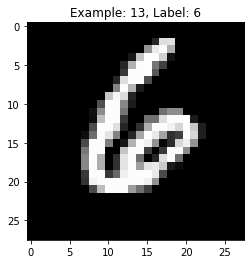

In [3]:
ind = 13
plt.imshow(x_train[ind], cmap='gray')
plt.title('Example: {}, Label: {}'.format(ind, y_train[ind]))


Before we can train a model, we need to one-hot encode the labels. This procedure takes a label, which is a scalar and converts it into a vector with $10$ dimensions, which has nine `0`'s and one `1`. The position of the `1` indicates the label. For instance the label `6` will become `[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]`. 

In [4]:
print('Before: ', y_train.shape, y_test.shape)

y_train = tf.keras.utils.to_categorical(y_train, 10)  # second parameter is the 
y_test = tf.keras.utils.to_categorical(y_test, 10)    # number of classes

print('After:  ', y_train.shape, y_test.shape)

Before:  (60000,) (10000,)
After:   (60000, 10) (10000, 10)


One final thing we'll need to do is to normalize the images. Images are usually represented as integers in the $[0, 255]$ range or as 32-bit floats in the $[0, 1]$ range. We usually prefer the latter so that we can use smaller learning rates and so that the weights don't need to take high values.

In [5]:
print('Before: min(x_train)={}, max(x_train)={}'.format(x_train.min(), x_train.max()))

x_train = x_train / 255.0
x_test = x_test / 255.0

print('After: min(x_train)={}, max(x_train)={}'.format(x_train.min(), x_train.max()))

Before: min(x_train)=0, max(x_train)=255
After: min(x_train)=0.0, max(x_train)=1.0


## Logistic Regression

Now, let's start off with a very simple model. We'll create a simple logistic regressor to classify the images. 

Since the logistic regressor requires a 1D input, we'll need to flatten the image to $28 \times 28 = 784$ pixels.

![](https://codelabs.developers.google.com/codelabs/cloud-tensorflow-mnist/img/d5222c6e3d15770a.png)



In [6]:
inp = tf.keras.layers.Input(shape=(28 * 28))
out = tf.keras.layers.Dense(10, activation='softmax')(inp)

logistic_regression = tf.keras.models.Model(inp, out)

logistic_regression.compile(optimizer='sgd', loss='categorical_crossentropy', 
                            metrics=['accuracy'])

logistic_regression.fit(x_train.reshape(-1, 28 * 28), y_train, epochs=10)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 73us/sample - loss: 0.7734 - accuracy: 0.8181
Epoch 2/10
60000/60000 [==============================] - 4s 69us/sample - loss: 0.4543 - accuracy: 0.8817
Epoch 3/10
60000/60000 [==============================] - 4s 69us/sample - loss: 0.4016 - accuracy: 0.8913
Epoch 4/10
60000/60000 [==============================] - 4s 67us/sample - loss: 0.3754 - accuracy: 0.8978
Epoch 5/10
60000/60000 [==============================] - 4s 68us/sample - loss: 0.3589 - accuracy: 0.9012
Epoch 6/10
60000/60000 [==============================] - 4s 66us/sample - loss: 0.3472 - accuracy: 0.9040
Epoch 7/10
60000/60000 [==============================] - 4s 68us/sample - loss: 0.3382 - accuracy: 0.9063
Epoch 8/10
60000/60000 [==============================] - 4s 68us/sample - loss: 0.3311 - accuracy: 0.9084
Epoch 9/10
60000/60000 [==============================] - 4s 68us/sample - loss: 0.3254 - accuracy: 0.9096
Epoch 10/10
60

In [7]:
print('Test set accuracy:', logistic_regression.evaluate(x_test.reshape(-1, 28 * 28), y_test)[1])

10000/10000 [==============================] - 1s 72us/sample - loss: 0.3059 - accuracy: 0.9163
Test set accuracy: 0.9163


An interesting property of logistic regression, is that because it has a direct mapping from input features to output classes, the weights essentially depict the importance of each input feature towards the final prediction. 

If we rearange these $784 \times 10$ weights to $10$, $28 \times 28$ arrays, we can visualize which pixels mattered the most towards classifying esch of the $10$ classes.

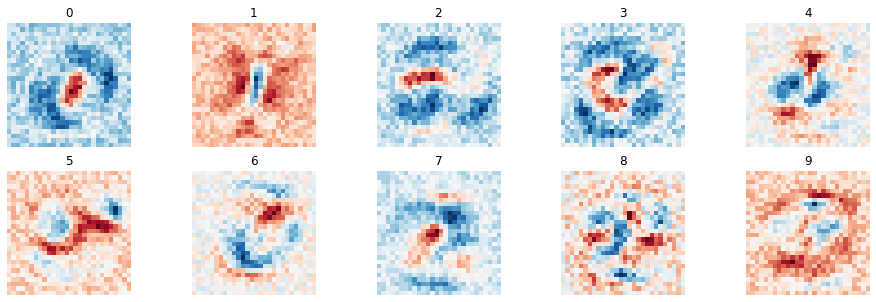

In [8]:
weights = logistic_regression.get_weights()[0]  # access the model's weights

plt.figure(figsize=(16, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    weight = weights[:,i].reshape([28,28])
    plt.title(i)
    plt.imshow(weight, cmap='RdBu')
    ax = plt.gca()
    ax.axis('off')

Blue pixels contribute positively towards that prediction while red pixels contribute negatively.

From the above we can begin to understand the reason for this model's high accuracy. Some numbers are, from their nature, easier to detect than others. For example the $0$ is always drawn like a circle with a hole in the middle.

## Multi-Layer Perceptron

Now, let's train an MLP, like the one we did last time.

In [9]:
inp = tf.keras.layers.Input(shape=(28 * 28))
hid = tf.keras.layers.Dense(100, activation='relu')(inp)
out = tf.keras.layers.Dense(10, activation='softmax')(hid)

mlp = tf.keras.models.Model(inp, out, name='MLP')

mlp.compile(optimizer='sgd', loss='categorical_crossentropy', 
                            metrics=['accuracy'])

mlp.fit(x_train.reshape(-1, 28 * 28), y_train, epochs=10)

print('Test set accuracy:', mlp.evaluate(x_test.reshape(-1, 28 * 28), y_test)[1])

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 73us/sample - loss: 0.6404 - accuracy: 0.8368
Epoch 2/10
60000/60000 [==============================] - 4s 72us/sample - loss: 0.3382 - accuracy: 0.9058
Epoch 3/10
60000/60000 [==============================] - 4s 71us/sample - loss: 0.2909 - accuracy: 0.9186
Epoch 4/10
60000/60000 [==============================] - 4s 72us/sample - loss: 0.2610 - accuracy: 0.9261
Epoch 5/10
60000/60000 [==============================] - 4s 70us/sample - loss: 0.2380 - accuracy: 0.9334
Epoch 6/10
60000/60000 [==============================] - 4s 72us/sample - loss: 0.2198 - accuracy: 0.9383
Epoch 7/10
60000/60000 [==============================] - 4s 71us/sample - loss: 0.2041 - accuracy: 0.9427
Epoch 8/10
60000/60000 [==============================] - 4s 72us/sample - loss: 0.1902 - accuracy: 0.9471
Epoch 9/10
60000/60000 [==============================] - 4s 70us/sample - loss: 0.1790 - accuracy: 0.9495
Epoch 10/10
10

This model did a bit better than the last time, however the model took a bit more time to train. Because the MLP does not have a direct mapping from input to output (instead the hidden layer comes in between), we cannot visualize the impact each input pixel has towards the final prediction.

## Training on Batches

Unfortunately the MNIST dataset isn't very indicative of an actual image classification problem, due to its small size. Most datasets range from hundreds of thousands to millions of images, while having a higher resolution. 
In most cases image datasets won't fit in memory to store as a numpy array (e.g. like we have `x_train` here), but will have to be loaded from the disk a few at a time. Even if they could be stored in memory, it wouldn't be effective for a model to see all of the images in order to calculate the total loss and compute the gradient. 

The solution is that the model just processes a small subset of the training set at each step and updates its parameters according to this. This subset is referred to as a **batch**. This leads to a variation of Gradient Descent, called [Stochastic Gradient Descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent), which is what **SGD** stands for (i.e. the optimizer that we've been using).

By Machine Learning terminology:

- an **iteration** is a single training step where the model generates predictions for a batch of samples, estimates their loss, computes the gradient of this loss with respect to the parameters and updates them accordingly.

- an **epoch** is the time at which the model has seen all samples in the training set. 

For example if we used a batch size of $200$ (i.e. each batch consists of $200$ images), this would mean that the training set would be split into $60,000 / 200 = 3,000$ batches. Consequently, an epoch would consist of $3,000$ iterations. 

In regular Gradient Descent, since the model is trained on the whole training set, the batch size would be equal to the training set size and an iteration would be the same as an epoch. 

The tradeoff between SGD and regular GD is that the first requires much more training steps to converge, but each step is much quicker. Additionally, since each batch's loss is only an approximation of the training set's loss, the parameters might be updated in a direction that isn't globally optimal. While this sounds like a bad thing, it could be actually beneficial because it allows exploring a larger area in the parameter space, which could help get over local minima or reduce overfitting.

After each epoch the training set is shuffled so that we get different samples in each batch. This whole procedure is done seemlessly in the `model.fit()` function, whoever we'll see how to tweak it in a future tutorial.

For the time being we can control the batch size (and consequently the number of iterations per epoch) through the `batch_size` parameter in the `.fit()` method.

In [10]:
# Train the model again with a batch size of 256
mlp.fit(x_train.reshape(-1, 28 * 28), y_train, epochs=10, batch_size=256)

print('Test set accuracy:', mlp.evaluate(x_test.reshape(-1, 28 * 28), y_test)[1])

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 1s 15us/sample - loss: 0.1604 - accuracy: 0.9553
Epoch 2/10
60000/60000 [==============================] - 1s 12us/sample - loss: 0.1591 - accuracy: 0.9558
Epoch 3/10
60000/60000 [==============================] - 1s 13us/sample - loss: 0.1580 - accuracy: 0.9562
Epoch 4/10
60000/60000 [==============================] - 1s 13us/sample - loss: 0.1569 - accuracy: 0.9566
Epoch 5/10
60000/60000 [==============================] - 1s 13us/sample - loss: 0.1559 - accuracy: 0.9568
Epoch 6/10
60000/60000 [==============================] - 1s 13us/sample - loss: 0.1549 - accuracy: 0.9568
Epoch 7/10
60000/60000 [==============================] - 1s 13us/sample - loss: 0.1538 - accuracy: 0.9576
Epoch 8/10
60000/60000 [==============================] - 1s 13us/sample - loss: 0.1528 - accuracy: 0.9576
Epoch 9/10
60000/60000 [==============================] - 1s 13us/sample - loss: 0.1519 - accuracy: 0.9578
Epoch 10/10
10

The type of Neural Network we've been using up till now is called a **Fully Connected (FC)** Neural Network, because for each layer, every one of its inputs are connected to all of its outputs.

## Convolutional Neural Networks

Convolutional Neural Networks (CNNs), are another type of Neural Networks, very popular when dealing with images. These networks employ **weight sharing** and **sparse connecticity** to reduce the number of parameters in each layer, allowing for the creation of deep networks. 

There are three main layers that are used in CNNs: convolutional, pooling and fully connected.

### Convolutional Layer

*Note: since we're dealing with images we'll be examining 2D convolution layers, but there are also 1D layers (e.g. for sequential data) and 3D layers (e.g. for volumetric data).*

*Note2: Also it's important to point out that the input of these 2D layers is a 2D array. This means that the image is passed to the layer in its original form and not flattened as we did before. This allows the layers to exploit the spatial structure of the images to extract features.*

#### Operation

A convolutional layer performs a 2D convolution operation on the input. We won't look into the [mathematical definition](https://en.wikipedia.org/wiki/Convolution) of this operation, rather how it affects an input image. Say we have the following $5 \times 5$ image:

![](https://ujwlkarn.files.wordpress.com/2016/07/screen-shot-2016-07-24-at-11-25-13-pm.png?w=254&h=230)

Additionally we have a $3 \times 3$ filter:

![](https://ujwlkarn.files.wordpress.com/2016/07/screen-shot-2016-07-24-at-11-25-24-pm.png?w=148&h=128)

The 2D convolution operation between these two is equivalent to passing the filter through the image and multiplying the two elementwise at each position to generate each element of the output. 

![](https://ujwlkarn.files.wordpress.com/2016/07/convolution_schematic.gif?w=268&h=196&zoom=2)

The output of the convolution is called a **feature map**. Different filters (or **kernels** as they're more commonly called) have [different effects][1] on the input image. A nice example for the effect different kernels can have can be found [here](http://setosa.io/ev/image-kernels/).

Let's try a simple example for ourselves.

[1]: https://en.wikipedia.org/wiki/Kernel_(image_processing)



Input shape:  (1, 28, 28, 1)
Output shape: (1, 26, 26, 3)


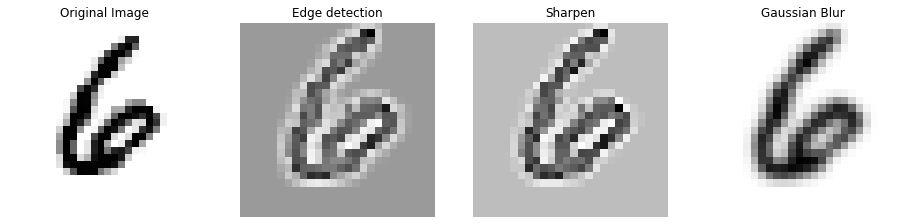

In [11]:
 # Input needs to be a 4D array with a shape of (num_images, height, widhth, channels)
image = x_train[ind][np.newaxis, ..., np.newaxis]

# Same thing for the filters
f1 = np.array([-1, -1, -1, -1, 8, -1, -1, -1, -1]).reshape((3, 3, 1, 1))  # edge detection
f2 = np.array([0, -1, 0, -1, 5, -1, 0, -1, 0]).reshape((3, 3, 1, 1))  # sharpen
f3 = np.array([1, 2, 1, 2, 4, 2, 1, 2, 1]).reshape((3, 3, 1, 1)) / 16  # gaussian blur

# Stack the three filters into one on their last dimension
filters = np.concatenate([f1, f2, f3], axis=-1)

# Compute the convolution operation
output = tf.nn.conv2d(image, filters, strides=(1, 1), padding='VALID', data_format='NHWC')

# Plot the results
plt.figure(figsize=(16, 4))

ax = plt.subplot(141)
ax.imshow(x_train[ind], cmap='Greys')
ax.axis('off')
ax.set_title('Original Image')

ax = plt.subplot(142)
ax.imshow(output[0, ..., 0], cmap='Greys')
ax.axis('off')
ax.set_title('Edge detection')

ax = plt.subplot(143)
ax.imshow(output[0, ..., 1], cmap='Greys')
ax.axis('off')
ax.set_title('Sharpen')

ax = plt.subplot(144)
ax.imshow(output[0, ..., 2], cmap='Greys')
ax.axis('off')
ax.set_title('Gaussian Blur')

print('Input shape: ', image.shape)
print('Output shape:', output.shape)

In a convolution layer, the values of the filter are **trainable parameters**. The idea is that the network will learn to extract whatever features it deems necessary from the images.

One more interesting thing to note is that the dimensions of the feature maps shrank a bit compared to the input image. This is to be expected due to the number of total positions in the input image that the filter can be placed in. 

#### Implementation Details

There are 4 main hyperparameters with which we can affect the befaviour of a convolution layer:

- Kernel **size** (i.e. the size of the filters). In the previous example we used $3 \times 3$ filters.
- The **number** of filters in a given layer (e.g. in the example we set 3 filters). Think of this as the size of the layer (it is equivalent to the number of neurons in a FC layer).
- The filter's **strides**. In the previous example we moved the filter by 1 pixel at each time. This isn't necessary always; we can make the filter move by more than 1 pixels at a time.  
 *Note: this will reduce the size of the output feature maps*.
- We can even allow the filter to go *outside* of the input image, so that the feature maps have the same size as the input image. This technique is called **padding**, because we need to *pad* the input image with some value to allow the filter to work on the the image's edges. There are a few types of padding like *zero padding* which pads the images with zeros (sometimes referred to as *same padding*) and not using any padding is commonly referred to as *valid padding*.

Additionally to these, in a convolutional layer we have the same hyperparameters as in a regular FC layer, e.g. the activation fucntion, the choice to use a bias or not and the weight initialization. The [ReLU][2] is the most common activation function used, while biases have proven to be not that necessary (a lot of popular architectures don't utilize biases).

#### Comparison to Fully Connected Layers

The major advantage of a convolutional layer compared to a FC one is that it has a lot less parameters. In the previous example we had an input image of $28 \times 28 = 784$ pixels and the output of that *layer* was $3$ feature maps of $26 \times 26$ pixels, for a total of $2,028$ pixels. In a FC layer, if we wanted the same dimensions we'd need to have $784 \times 2,028 = 1,589,952‬$ parameters. How many did we need in the example? Just $27$!



[2]: https://en.wikipedia.org/wiki/Rectifier_(neural_networks)

In [12]:
inp = tf.keras.layers.Input((28 , 28, 1))
fl = tf.keras.layers.Flatten()(inp)
fc = tf.keras.layers.Dense(26 * 26 * 3, use_bias=False)(fl)

m = tf.keras.models.Model(inp, fc, name='Fully Connected')

m.summary()

print()

inp = tf.keras.layers.Input((28 , 28, 1))
conv = tf.keras.layers.Conv2D(3, (3, 3), use_bias=False)(inp)
fl = tf.keras.layers.Flatten()(conv)

m = tf.keras.models.Model(inp, fl, name='Convolution')

m.summary()

Model: "Fully Connected"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2028)              1589952   
Total params: 1,589,952
Trainable params: 1,589,952
Non-trainable params: 0
_________________________________________________________________

Model: "Convolution"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 26, 26, 3)         27        
___________________

### Pooling Layers

*Note: Again we'll be referring to 2D pooling layers*.

A pooling layer decreases the size of its input through some sort of spatial subsampling. Pooling layers again have a sort of filter that slides through the input image and performs some operation at each position. Depending on the operation performed, we have different types of pooling layers (e.g. max, sum, average). The difference between this and convolution layers is that here the inputs are **not** transformed with a linear transformation, but **described** in some way. This means that pooling layers have **no trainable parameters**. 

For example, the most common type is **max pooling**.

![](https://ujwlkarn.files.wordpress.com/2016/08/screen-shot-2016-08-10-at-3-38-39-am.png?w=500)

In this operation the filter does keeps the maximum of each position in the input image. 

#### Implementation details

We are faced with some of the same design choices here as we were with convolutions. Pooling layers have:

- **size**: in the above example they're $2 \times $2.
- **strides**: again above we have strides of $2$ both horizontally and vertically.
- **padding**: above we used "valid" pading (i.e. no padding).

Let's see an example.

Input shape:  (1, 28, 28, 1)
Output shape: (1, 14, 14, 1)


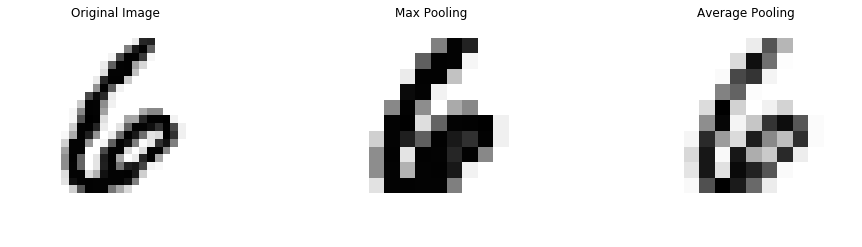

In [13]:
# Perform a max pooling operation on the previous image
max_pool = tf.nn.max_pool2d(image, ksize=(2, 2), strides=(2, 2), padding='VALID')
avg_pool = tf.nn.avg_pool2d(image, ksize=(2, 2), strides=(2, 2), padding='VALID')

# Plot the results
plt.figure(figsize=(16, 4))

ax = plt.subplot(131)
ax.imshow(x_train[ind], cmap='Greys')
ax.axis('off')
ax.set_title('Original Image')

ax = plt.subplot(132)
ax.imshow(max_pool[0, ..., 0], cmap='Greys')
ax.axis('off')
ax.set_title('Max Pooling')

ax = plt.subplot(133)
ax.imshow(avg_pool[0, ..., 0], cmap='Greys')
ax.axis('off')
ax.set_title('Average Pooling')

print('Input shape: ', image.shape)
print('Output shape:', max_pool.shape)

Note that the two pooled images are drastically subsampled (one fourth of the original pixels).

#### Why use pooling layers?

There are several reasons often cited as to why pooling layers are beneficial:

- They subsample their input which can lead to the **reduction** of a network's parameters.
- They provide some form of **invariance** to small changes in the input.
- They make the representation independent of scale (**equivariance**).

On the other hand, more and more CNNs are beginning to dump pooling layers altogether in favor of subsampling through convolution layers with a stride larger than $1$, so they may not be so necessary.

### Making predictions

Convolution and pooling layers are good for **extracting features** from the images. However, we still need a way to generate predictions based on these features. The solution is to add a FC layer at the end of the network, to classify images (or any other task).

Now we can put it all together and create our first CNN.

In [14]:
# Input layer
# Note: we are passing each image as a 3D array: (height, width, channels)
# So the actual input of the CNN will be 4D: (batch size, height, width, channels)
inp = tf.keras.layers.Input((28, 28, 1))

# First convolutional layer:
# 32 filters, a kernel size of 6x6, strides of 1, zero (same) padding and ReLU activated
c1 = tf.keras.layers.Conv2D(8, kernel_size=(6, 6), activation='relu', padding='same')(inp)

# Second convolutional layer:
# 64 filters, a kernel size of 6x6, strides of 1, zero padding and ReLU activated
c2 = tf.keras.layers.Conv2D(16, kernel_size=(6, 6), activation='relu', padding='same')(c1)

# First max pooling layer:
# A kernel size of 2x2, strides of 2 and zero padding
p1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(c2)

# Third convolutional layer:
# 128 filters, a kernel size of 4x4, strides of 1, same padding and ReLU activated
c3 = tf.keras.layers.Conv2D(32, kernel_size=(4, 4), activation='relu', padding='same')(p1)

# Fourth convolutional layer:
# 256 filters, a kernel size of 4x4, strides of 1, same padding and ReLU activated
c4 = tf.keras.layers.Conv2D(64, kernel_size=(4, 4), activation='relu', padding='same')(c3)

# Second pooling layer:
# A kernel size of 2x2, strides of 2 and zero padding
p2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same')(c4)

# Flatten layer:
# This is used to convert the 3D input to a 1D vector, required by the FC layers  
fl = tf.keras.layers.Flatten()(p2)

# Fully Connected layer:
# Output layer of the model, same as we had with the MLP
out = tf.keras.layers.Dense(10, activation='softmax')(fl)

cnn = tf.keras.models.Model(inputs=inp, outputs=out, name='CNN')

# Store the weights so that we can re-initialize the model later
weights = cnn.get_weights()

cnn.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
h = cnn.fit(x_train[..., np.newaxis], y_train, epochs=10, batch_size=256)

print('Test set accuracy:', cnn.evaluate(x_test[..., np.newaxis], y_test)[1])

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 86us/sample - loss: 1.5164 - accuracy: 0.5224
Epoch 2/10
60000/60000 [==============================] - 4s 75us/sample - loss: 0.3313 - accuracy: 0.9011
Epoch 3/10
60000/60000 [==============================] - 4s 75us/sample - loss: 0.2105 - accuracy: 0.9373
Epoch 4/10
60000/60000 [==============================] - 4s 74us/sample - loss: 0.1600 - accuracy: 0.9517
Epoch 5/10
60000/60000 [==============================] - 5s 76us/sample - loss: 0.1317 - accuracy: 0.9605
Epoch 6/10
60000/60000 [==============================] - 4s 74us/sample - loss: 0.1138 - accuracy: 0.9652
Epoch 7/10
60000/60000 [==============================] - 5s 75us/sample - loss: 0.1016 - accuracy: 0.9696
Epoch 8/10
60000/60000 [==============================] - 4s 75us/sample - loss: 0.0912 - accuracy: 0.9727
Epoch 9/10
60000/60000 [==============================] - 5s 75us/sample - loss: 0.0849 - accuracy: 0.9741
Epoch 10/10
10

The CNN was chosen strategically so that it has around the same number of parameters that the MLP did. This can be easily confirmed.

In [15]:
cnn.summary()
print()
mlp.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 8)         296       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        4624      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0       

So, convolution layers make it so we can create **much deeper** networks, with the same number of parameters. This leads to the extraction of higher-level features from the input images, which in turn allows for the creation of much more effective image classifiers.

This can be seen by the elevated performance.

## Keras Callbacks

One of the main draws to keras is its simple interface for training models: `model.fit()`. This abstracts the training loop into a simple method, which offers a very skleran-like feel to training even complex Deep Neural Networks. While simplicity is always welcome, it is through our **loss of control** over the training process.

*What if we want to reduce the learning rate during training? What if we want to [increase the batch size](https://arxiv.org/abs/1711.00489)? What if we want to save the model every $x$ epochs or iterations or log the model's performance through training?*

Keras offers a way of interfering with the training process at certain points, such as the beginning/end of an iteration or the beginning/end of an epoch.

Let's examine the most common callback: [`History`](https://keras.io/callbacks/#history). This callback is automatically applied to every keras model and is returned from the `.fit()` method. If you reacll we stored this output to a variable called `h`.  

In [16]:
h

`History` keeps a dictionary with the loss and metrics as measured at the end of each epoch.

In [17]:
h.history

{'accuracy': [0.52236664,
  0.90108335,
  0.93728334,
  0.95166665,
  0.9604667,
  0.9652,
  0.9696,
  0.9726833,
  0.9740667,
  0.97671664],
 'loss': [1.5164427970727286,
  0.331268225034078,
  0.21052604314486187,
  0.16003423953056337,
  0.13169671385685602,
  0.11383970307906469,
  0.10159371053377787,
  0.09121028393904368,
  0.08489738444884617,
  0.07760895399649938]}

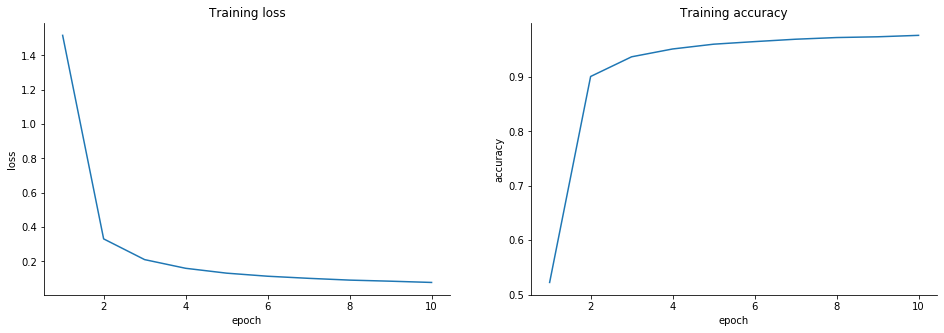

In [18]:
plt.figure(figsize=(16, 5))

ax = plt.subplot(121)
ax.plot(range(1, 11), h.history['loss'])
ax.set_title('Training loss')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = plt.subplot(122)
ax.plot(range(1, 11), h.history['accuracy'])
ax.set_title('Training accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Besides the default `History` callback there are a lot more available. Some other examples of popular callbacks are [`ModelCheckpoint`](https://keras.io/callbacks/#modelcheckpoint), [`EarlyStopping`](https://keras.io/callbacks/#earlystopping), [`LearningRateScheduler`](https://keras.io/callbacks/#learningratescheduler) and [`ReduceLROnPlateau`](https://keras.io/callbacks/#reducelronplateau).

These four callbacks are very useful to know, so we'll see them in more detail:

`ModelCheckpoint` is used to store the model every $x$ epochs. The cool thing with this callback is that we can set it to monitor a metric (even a validation one) and save the weights only if they are better than the previous stored.

This ensures that the weights we have stored are actually the best and will help combat overfitting if set to monitor a validation metric

`EarlyStopping` again monitors a metric and terminates the training loop when that monitor stops improving. What *stops improving* actually means and over how many epochs does it need to not improve to terminate is up to us.

`LearningRateScheduler` allows us to change the learing rate based on a predefined schedule.

`ReduceLROnPlateau` again monitors a certain metric and when that metric stops improving, it reduces the learning rate.


In [19]:
# Model Checkpoint
chp = tf.keras.callbacks.ModelCheckpoint('best_weights_cnn.h5', 
                                         monitor='val_accuracy', 
                                         save_best_only=True)
# first parameter is the path to the file we want the weights to be stored
# we want to monitor the validation accuracy, i.e. 'val_accuracy'.
# we want to store the weights only if they are better than the previously-stored weights 

# Reduce LR on Plateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                                 patience=3, cooldown=1,
                                                 min_delta=0.01, verbose=1)
# we'll monitor the validation loss for theis callback
# if it stagnates for 3 epochs (i.e. 'patience=3')
# it will be reduced by halp (i.e. 'factor=0.5')
# then it will have to wait an epoch for normal operation to resume (i.e. 'cooldown=1')
# 'min_delta=0.01' means that if the loss doesn't drop by more than 0.01 trigger the reduction
# finally, we'll add a verbosity to see when the reduction is triggered

# Restore the initial weights of the model and compile it again
cnn.set_weights(weights)
cnn.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model again from scratch
h = cnn.fit(x_train[..., np.newaxis], y_train, epochs=20, batch_size=256, 
            callbacks=[chp, reduce_lr], validation_data=(x_test[..., np.newaxis], y_test))

print('Test set accuracy:', cnn.evaluate(x_test[..., np.newaxis], y_test)[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 85us/sample - loss: 1.5158 - accuracy: 0.5206 - val_loss: 0.4521 - val_accuracy: 0.8682
Epoch 2/20
60000/60000 [==============================] - 5s 80us/sample - loss: 0.3342 - accuracy: 0.8992 - val_loss: 0.2545 - val_accuracy: 0.9258
Epoch 3/20
60000/60000 [==============================] - 5s 80us/sample - loss: 0.2120 - accuracy: 0.9366 - val_loss: 0.2004 - val_accuracy: 0.9398
Epoch 4/20
60000/60000 [==============================] - 5s 80us/sample - loss: 0.1604 - accuracy: 0.9525 - val_loss: 0.1296 - val_accuracy: 0.9594
Epoch 5/20
60000/60000 [==============================] - 5s 80us/sample - loss: 0.1324 - accuracy: 0.9607 - val_loss: 0.1534 - val_accuracy: 0.9534
Epoch 6/20
60000/60000 [==============================] - 5s 80us/sample - loss: 0.1137 - accuracy: 0.9657 - val_loss: 0.1355 - val_accuracy: 0.9571
Epoch 7/20
60000/60000 [==============================] 

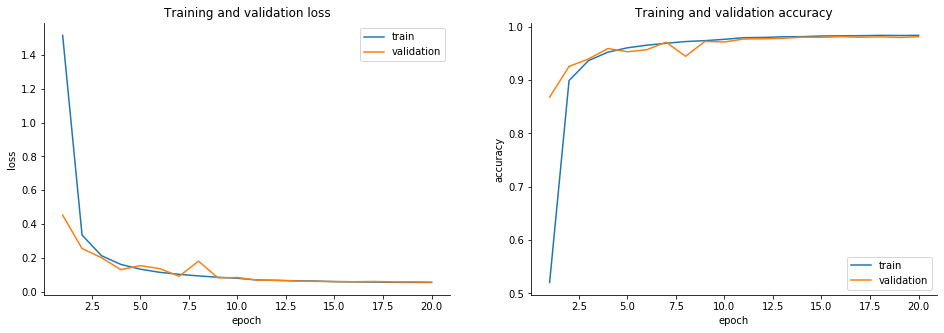

In [20]:
plt.figure(figsize=(16, 5))

ax = plt.subplot(121)
ax.plot(range(1, 21), h.history['loss'], label='train')
ax.plot(range(1, 21), h.history['val_loss'], label='validation')
ax.set_title('Training and validation loss')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = plt.subplot(122)
ax.plot(range(1, 21), h.history['accuracy'], label='train')
ax.plot(range(1, 21), h.history['val_accuracy'], label='validation')
ax.set_title('Training and validation accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

Some things to note:
1. Callbacks are passed always as a **list** to the `callbacks` parameter of the `model.fit()` method, even if we are using only one callback.
2. To monitor validation metrics, such as `val_loss` or `val_acc`, you need to feed the `model.fit()` function with validation data. These are evaluated **at the end of each epoch**.

The best weights are stored in the current directory because we didn't denote a filepath.

In [21]:
!ls

best_weights_cnn_2.h5  best_weights_cnn.h5  sample_data


One more callback that gives us a bit more flexibility to change the learning rate is the `LearningRateScheduler`. First, we'll need to devise a schedue for the learning rate.

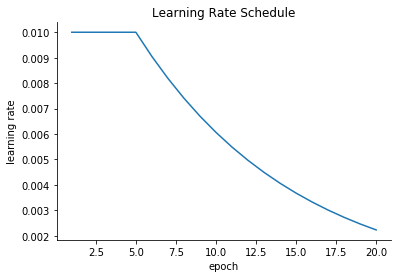

In [22]:
def schedule(epoch):
  '''
  Function that takes the epoch as an argument and returns a float
  that will be used as the learning rate for that epoch.
  '''
  if epoch < 5:
    return 0.01

  else:
    return 0.01 * tf.math.exp(0.1 * (5 - epoch))

epochs = range(1, 21)
lrs = [schedule(e) for e in epochs]

ax = plt.subplot(111)
plt.plot(epochs, lrs)
ax.set_title('Learning Rate Schedule')
ax.set_xlabel('epoch')
ax.set_ylabel('learning rate')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [23]:
#Learning Rate Scheduler
lr_sch = tf.keras.callbacks.LearningRateScheduler(schedule)

# Model Checkpoint
chp = tf.keras.callbacks.ModelCheckpoint('best_weights_cnn_2.h5', 
                                         monitor='val_accuracy', 
                                         save_best_only=True)

# Restore the initial weights of the model and fit it again
cnn.set_weights(weights)
cnn.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
h2 = cnn.fit(x_train[..., np.newaxis], y_train, epochs=20, batch_size=256, 
             callbacks=[chp, lr_sch], validation_data=(x_test[..., np.newaxis], y_test))

print('Test set accuracy:', cnn.evaluate(x_test[..., np.newaxis], y_test)[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 88us/sample - loss: 1.5136 - accuracy: 0.5219 - val_loss: 0.5081 - val_accuracy: 0.8422
Epoch 2/20
60000/60000 [==============================] - 5s 80us/sample - loss: 0.3332 - accuracy: 0.9001 - val_loss: 0.2489 - val_accuracy: 0.9260
Epoch 3/20
60000/60000 [==============================] - 5s 80us/sample - loss: 0.2104 - accuracy: 0.9367 - val_loss: 0.1724 - val_accuracy: 0.9444
Epoch 4/20
60000/60000 [==============================] - 5s 80us/sample - loss: 0.1587 - accuracy: 0.9528 - val_loss: 0.1607 - val_accuracy: 0.9484
Epoch 5/20
60000/60000 [==============================] - 5s 81us/sample - loss: 0.1324 - accuracy: 0.9606 - val_loss: 0.1045 - val_accuracy: 0.9656
Epoch 6/20
60000/60000 [==============================] - 5s 80us/sample - loss: 0.1149 - accuracy: 0.9653 - val_loss: 0.1029 - val_accuracy: 0.9658
Epoch 7/20
60000/60000 [==============================] 

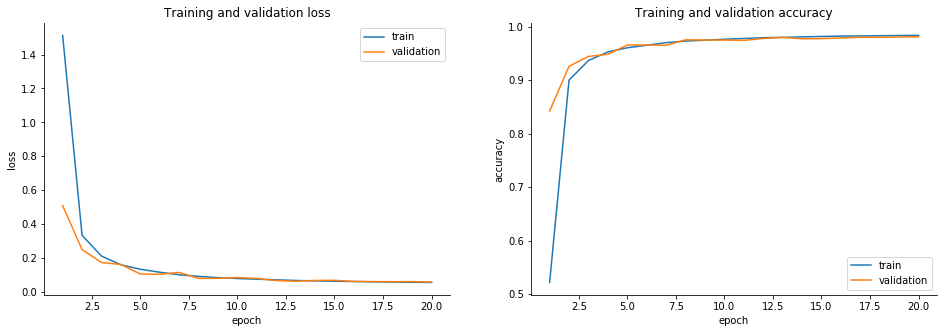

In [24]:
plt.figure(figsize=(16, 5))

ax = plt.subplot(121)
ax.plot(range(1, 21), h2.history['loss'], label='train')
ax.plot(range(1, 21), h2.history['val_loss'], label='validation')
ax.set_title('Training and validation loss')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax = plt.subplot(122)
ax.plot(range(1, 21), h2.history['accuracy'], label='train')
ax.plot(range(1, 21), h2.history['val_accuracy'], label='validation')
ax.set_title('Training and validation accuracy')
ax.set_xlabel('epoch')
ax.set_ylabel('accuracy')
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [25]:
!ls

best_weights_cnn_2.h5  best_weights_cnn.h5  sample_data


Since we have the weights for both models, we can easily compare them to see which one is better.

In [26]:
cnn.load_weights('best_weights_cnn.h5')
preds_plateau = np.argmax(cnn.predict(x_test[..., np.newaxis]), axis=1)
correct_preds_p = np.sum(preds_plateau == np.argmax(y_test, axis=1))

cnn.load_weights('best_weights_cnn_2.h5')
preds_schedule = np.argmax(cnn.predict(x_test[..., np.newaxis]), axis=1)
correct_preds_s = np.sum(preds_schedule == np.argmax(y_test, axis=1))

print('ReduleLROnPlateau accuracy:     {:.3f}'.format(correct_preds_p / len(y_test)))
print('LearningRateScheduler accuracy: {:.3f}'.format(correct_preds_s / len(y_test)))
print()
print('Number of wrong predictions: {}/{}'.format(len(y_test) - correct_preds_p, len(y_test)))
print('Number of wrong predictions: {}/{}'.format(len(y_test) - correct_preds_s, len(y_test)))

ReduleLROnPlateau accuracy:     0.982
LearningRateScheduler accuracy: 0.981

Number of wrong predictions: 184/10000
Number of wrong predictions: 189/10000


In the next tutorial we'll focus on a tool that TensorFlow offers for visualization. 